In [137]:
install.packages("readr")
install.packages("tsibble")

library(readr)
library(dplyr)
library(lubridate)
library(dplyr)
library(tidyr)
library(readr)
library(ggplot2)
library(tsibble)
library(ggplot2)
library(fpp3)
library(fable)
library(feasts)

Warning message:
"package 'readr' is in use and will not be installed"
Warning message:
"package 'tsibble' is in use and will not be installed"


**Load Data**

In [186]:
calendar <- read_csv("calendar_afcs2025.csv")  # date, event_type, week_id
sell_prices <- read_csv("sell_prices_afcs2025.csv")  # week_id, item_id, price
sales_data  <- read_csv("sales_train_validation_afcs2025.csv")  # item_id, product_type, items_sold

Rows: 1969 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): date, weekday, event_name_1, event_type_1, event_name_2, event_type_2
dbl (5): wm_yr_wk, wday, month, year, snap_TX

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 185260 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): store_id, item_id
dbl (2): wm_yr_wk, sell_price

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 823 Columns: 1914
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): id
dbl (1913): d_

***Calendar***

In [195]:
# Transform date format to date and ensure that dates are in chronological order
calendar <- calendar %>%
  mutate(date = as.Date(date, format = "%m/%d/%Y"))%>%
 arrange(date)


# Add column day_id
calendar <- calendar %>%   
  mutate(day_id = paste0("id_", row_number()))

In [204]:
# rows and columns
no_of_rows = nrow(calendar)
no_of_cols = ncol(calendar)
col_names = colnames(calendar)

# Dates
range = range(calendar$date)

# NA values
rows_na = colSums(is.na(calendar))

# Duplicates
dupls = anyDuplicated(calendar)


print("Number of rows") 
print(no_of_rows)
print("-----------------------")
print("Number of columns")
print(no_of_cols)
print("-----------------------")
print("Column names:")
print(col_names)
print("-----------------------")
print("Period covered")
print(range)
print("-----------------------")
print("Gaps in dates")
print(gaps_in_dates)
print("-----------------------")
print("Rows with na values")
print(rows_na)
print("-----------------------")
print("Number of duplicates")
print(dupls)


[1] "Number of rows"
[1] 1969
[1] "-----------------------"
[1] "Number of columns"
[1] 12
[1] "-----------------------"
[1] "Column names:"
 [1] "date"         "wm_yr_wk"     "weekday"      "wday"         "month"       
 [6] "year"         "event_name_1" "event_type_1" "event_name_2" "event_type_2"
[11] "snap_TX"      "day_id"      
[1] "-----------------------"
[1] "Period covered"
[1] "2011-01-29" "2016-06-19"
[1] "-----------------------"
[1] "Gaps in dates"
# A tibble: 1 × 1
  .gaps
  <lgl>
1 FALSE
[1] "-----------------------"
[1] "Rows with na values"
        date     wm_yr_wk      weekday         wday        month         year 
           0            0            0            0            0            0 
event_name_1 event_type_1 event_name_2 event_type_2      snap_TX       day_id 
        1807         1807         1964         1964            0            0 
[1] "-----------------------"
[1] "Number of duplicates"
[1] 0


Colendard  contains information about the dates the products are sold.
Calendar contains columns:  
- date: The date in a "y-m-d" format.
- wm_yr_wk: The id of the week the date belongs to
- weekday: The type of the day (Saturday, Sunday, …, Friday).
- wday: The id of the weekday, starting from Saturday.
-  month: The month of the date.
-  year: The year of the date.
-  event_name_1: If the date includes an event, the name of this event.
-  event_type_1: If the date includes an event, the type of this event.
-  event_name_2: If the date includes a second event, the name of this event.
-  event_type_2: If the date includes a second event, the type of this event.
-  snap_TX: A binary variable (0 or 1) indicating whether the stores of TX, allow SNAP3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

The dataset covers the perido from 29/01/2011 to 19/06/2011. 
There are 1807 NA values in the event_type_1 columns and 1964 NA values in the event_type_2 column, indicating that there were no events on the corresponding dates.  


**Sell Prices**

In [205]:
# rows and columns
no_of_rows = nrow(sell_prices)
no_of_cols = ncol(sell_prices)
col_names = colnames(sell_prices)

# NA values
rows_na = colSums(is.na(sell_prices))

# Duplicates
dupls = anyDuplicated(sell_prices)


print("Number of rows") 
print(no_of_rows)
print("-----------------------")
print("Number of columns")
print(no_of_cols)
print("-----------------------")
print("Column names:")
print(col_names)
print("-----------------------")

print("Rows with na values")
print(rows_na)
print("-----------------------")
print("Number of duplicates")
print(dupls)


[1] "Number of rows"
[1] 185260
[1] "-----------------------"
[1] "Number of columns"
[1] 4
[1] "-----------------------"
[1] "Column names:"
[1] "store_id"   "item_id"    "wm_yr_wk"   "sell_price"
[1] "-----------------------"
[1] "Rows with na values"
  store_id    item_id   wm_yr_wk sell_price 
         0          0          0          0 
[1] "-----------------------"
[1] "Number of duplicates"
[1] 0


**Sales**

split column id to store_id and item_id, so they match with the corresponding columns from sell_prices and calendar:
item_id: item_id, dept_id, cat_id
store_id: state_id, dtate_store_id  

Convert dataset to long format. Create column named day_id that matches with calendar's day_id and column units sold that contains information about the number of units sold per day. 

In [210]:
sales_nc <- sales_data %>%
  separate(
    id,
    into = c("item_id", "dept_id", "cat_id", "state_id", "state_store_id", "dataset_name"),
    sep = "_"
  )%>%
  mutate(
    store_id = paste(state_id, state_store_id, sep = "_"),
    item_id = paste(item_id, dept_id, cat_id, sep = "_")  
  ) %>%
  select(-state_id, -state_store_id)
sales <- sales_nc %>%
  pivot_longer(
    cols = starts_with("d_"),
    names_to  = "day_id",
    names_transform = list(day_id = ~ sub("^d_", "id_", .)),
    values_to = "units_sold"
  )

In [212]:
# rows and columns
no_of_rows = nrow(sales)
no_of_cols = ncol(sales)
col_names = colnames(sales)

# NA values
rows_na = colSums(is.na(sales))

# Duplicates
dupls = anyDuplicated(sales)


print("Number of rows") 
print(no_of_rows)
print("-----------------------")
print("Number of columns")
print(no_of_cols)
print("-----------------------")
print("Column names:")
print(col_names)
print("-----------------------")

print("Rows with na values")
print(rows_na)
print("-----------------------")
print("Number of duplicates")
print(dupls)

summary(sales["units_sold"])

[1] "Number of rows"
[1] 1574399
[1] "-----------------------"
[1] "Number of columns"
[1] 7
[1] "-----------------------"
[1] "Column names:"
[1] "item_id"      "dept_id"      "cat_id"       "dataset_name" "store_id"    
[6] "day_id"       "units_sold"  
[1] "-----------------------"
[1] "Rows with na values"
     item_id      dept_id       cat_id dataset_name     store_id       day_id 
           0            0            0            0            0            0 
  units_sold 
           0 
[1] "-----------------------"
[1] "Number of duplicates"
[1] 0


   units_sold     
 Min.   :  0.000  
 1st Qu.:  0.000  
 Median :  0.000  
 Mean   :  1.904  
 3rd Qu.:  1.000  
 Max.   :385.000  

The dataset has 1574399 rows. There are no missing values.  
The mean number of units sold was 1.904. 

**Join calendar and sales information**  
A left join keeps all rows from the left table and adds matching columns from the right table. In this case we use this type of join, because we want keep all information from sales, but not information from calendar that are actually useless

In [214]:
calendar_sales <- sales%>%
  left_join(calendar, by = "day_id")

head(calendar_sales)

item_id,dept_id,cat_id,dataset_name,store_id,day_id,units_sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
FOODS_3_001,3,001,validation,TX_3,id_1,0,2011-01-29,11101,Saturday,1,1,2011,NA,NA,NA,NA,0
FOODS_3_001,3,001,validation,TX_3,id_2,2,2011-01-30,11101,Sunday,2,1,2011,NA,NA,NA,NA,0
FOODS_3_001,3,001,validation,TX_3,id_3,1,2011-01-31,11101,Monday,3,1,2011,NA,NA,NA,NA,0
FOODS_3_001,3,001,validation,TX_3,id_4,3,2011-02-01,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1
FOODS_3_001,3,001,validation,TX_3,id_5,0,2011-02-02,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0
FOODS_3_001,3,001,validation,TX_3,id_6,0,2011-02-03,11101,Thursday,6,2,2011,NA,NA,NA,NA,1


**Join weekly prices and calendar_sales**

In [215]:
full_dataset <- calendar_sales %>%
  left_join(
    sell_prices,
    by = c("store_id", "item_id", "wm_yr_wk")
  )
head(full_dataset)

item_id,dept_id,cat_id,dataset_name,store_id,day_id,units_sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
FOODS_3_001,3,001,validation,TX_3,id_1,0,2011-01-29,11101,Saturday,1,1,2011,NA,NA,NA,NA,0,2.28
FOODS_3_001,3,001,validation,TX_3,id_2,2,2011-01-30,11101,Sunday,2,1,2011,NA,NA,NA,NA,0,2.28
FOODS_3_001,3,001,validation,TX_3,id_3,1,2011-01-31,11101,Monday,3,1,2011,NA,NA,NA,NA,0,2.28
FOODS_3_001,3,001,validation,TX_3,id_4,3,2011-02-01,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1,2.28
FOODS_3_001,3,001,validation,TX_3,id_5,0,2011-02-02,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0,2.28
FOODS_3_001,3,001,validation,TX_3,id_6,0,2011-02-03,11101,Thursday,6,2,2011,NA,NA,NA,NA,1,2.28


**Data Exploration**

Data types.  


In [216]:
str(full_dataset)

tibble [1,574,399 × 19] (S3: tbl_df/tbl/data.frame)
 $ item_id     : chr [1:1574399] "FOODS_3_001" "FOODS_3_001" "FOODS_3_001" "FOODS_3_001" ...
 $ dept_id     : chr [1:1574399] "3" "3" "3" "3" ...
 $ cat_id      : chr [1:1574399] "001" "001" "001" "001" ...
 $ dataset_name: chr [1:1574399] "validation" "validation" "validation" "validation" ...
 $ store_id    : chr [1:1574399] "TX_3" "TX_3" "TX_3" "TX_3" ...
 $ day_id      : chr [1:1574399] "id_1" "id_2" "id_3" "id_4" ...
 $ units_sold  : num [1:1574399] 0 2 1 3 0 0 1 0 2 1 ...
 $ date        : Date[1:1574399], format: "2011-01-29" "2011-01-30" ...
 $ wm_yr_wk    : num [1:1574399] 11101 11101 11101 11101 11101 ...
 $ weekday     : chr [1:1574399] "Saturday" "Sunday" "Monday" "Tuesday" ...
 $ wday        : num [1:1574399] 1 2 3 4 5 6 7 1 2 3 ...
 $ month       : num [1:1574399] 1 1 1 2 2 2 2 2 2 2 ...
 $ year        : num [1:1574399] 2011 2011 2011 2011 2011 ...
 $ event_name_1: chr [1:1574399] NA NA NA NA ...
 $ event_type_1: chr [1:1

In [217]:
no_of_rows = nrow(full_dataset)
no_of_cols = ncol(full_dataset)
col_names = colnames(full_dataset)

# NA values
rows_na = colSums(is.na(full_dataset))

# Duplicates
dupls = anyDuplicated(full_dataset)


print("Number of rows") 
print(no_of_rows)
print("-----------------------")
print("Number of columns")
print(no_of_cols)
print("-----------------------")
print("Column names:")
print(col_names)
print("-----------------------")

print("Rows with na values")
print(rows_na)
print("-----------------------")
print("Number of duplicates")
print(dupls)

[1] "Number of rows"
[1] 1574399
[1] "-----------------------"
[1] "Number of columns"
[1] 19
[1] "-----------------------"
[1] "Column names:"
 [1] "item_id"      "dept_id"      "cat_id"       "dataset_name" "store_id"    
 [6] "day_id"       "units_sold"   "date"         "wm_yr_wk"     "weekday"     
[11] "wday"         "month"        "year"         "event_name_1" "event_type_1"
[16] "event_name_2" "event_type_2" "snap_TX"      "sell_price"  
[1] "-----------------------"
[1] "Rows with na values"
     item_id      dept_id       cat_id dataset_name     store_id       day_id 
           0            0            0            0            0            0 
  units_sold         date     wm_yr_wk      weekday         wday        month 
           0            0            0            0            0            0 
        year event_name_1 event_type_1 event_name_2 event_type_2      snap_TX 
           0      1447657      1447657      1571107      1571107            0 
  sell_price 
      3

In [221]:
# Proportions of missing values for event 1 and event 2 in calendar dataset vs full dataset

mean(is.na(calendar$event_name_1))
mean(is.na(full_dataset$event_name_1))

mean(is.na(calendar$event_name_2))
mean(is.na(full_dataset$event_name_2))

[1] 0.9177247

[1] 0.9194982

[1] 0.9974606

[1] 0.997909

In [222]:
# Proportion of missing prices at daily level
mean(is.na(full_dataset$sell_price))

# Proportion of missing prices at weekly level
mean(
  is.na(
    full_dataset %>%
      distinct(store_id, item_id, wm_yr_wk, sell_price) %>%
      pull(sell_price)
  )
)


[1] 0.208195

[1] 0.2076523

The dataset containing all information consists of 1574399 rows, which is identical to the number of rows in the sales dataset.  
The dataset has 1447657 and 1571106 missing values for event type 1 and 2, respectively. These number are larger than the corresponding numbers in dataset calendar, however the proportion of missing values in the datasets match, indicating that the missing event information is expected and correctly propagated through the join.  
The missing sell_price values occur on weeks where no price was recorded (e.g., the item was not sold or not available), and these weekly gaps are repeated across daily observations after joining prices to the sales data. This is confirmed by the fact that the proportion of missing values on a daily basis is similar to the proportion of missing values on a weekly basis. 

Zero sales and missing sales

In [97]:
full_dataset %>%
  summarise(
    zero_sales = sum(units_sold == 0, na.rm = TRUE),
    na_sales   = sum(is.na(units_sold))
  )


zero_sales,na_sales
<int>,<int>
978441,0


Date Continuity

In [98]:
full_dataset %>%
  arrange(store_id, item_id, date) %>%
  group_by(store_id, item_id) %>%
  summarise(
    min_date = min(date),
    max_date = max(date),
    n_days   = n(), #number of rows in data 
    span     = as.integer(max_date - min_date) + 1, # number of days with data
    .groups = "drop"
  ) %>%
  filter(n_days != span)


store_id,item_id,min_date,max_date,n_days,span
<chr>,<chr>,<date>,<date>,<int>,<dbl>


There are no missing dates

Summary

In [223]:
summary(full_dataset$units_sold)
summary(full_dataset$sell_price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.904   1.000 385.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.02    1.88    2.50    2.85    3.50   19.48  327782 

Price per date

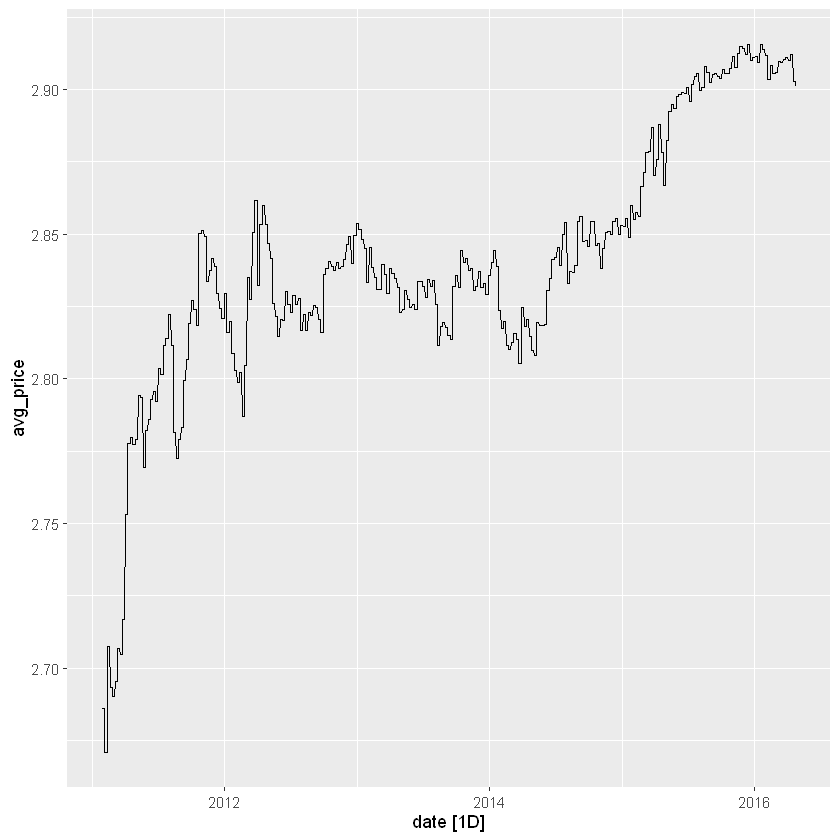

In [224]:
full_dataset %>%
  filter(!is.na(sell_price)) %>%
  group_by(date) %>%
  summarise(avg_price = mean(sell_price)) %>%
  as_tsibble(index = date) %>%
  autoplot(avg_price)


Price - Event

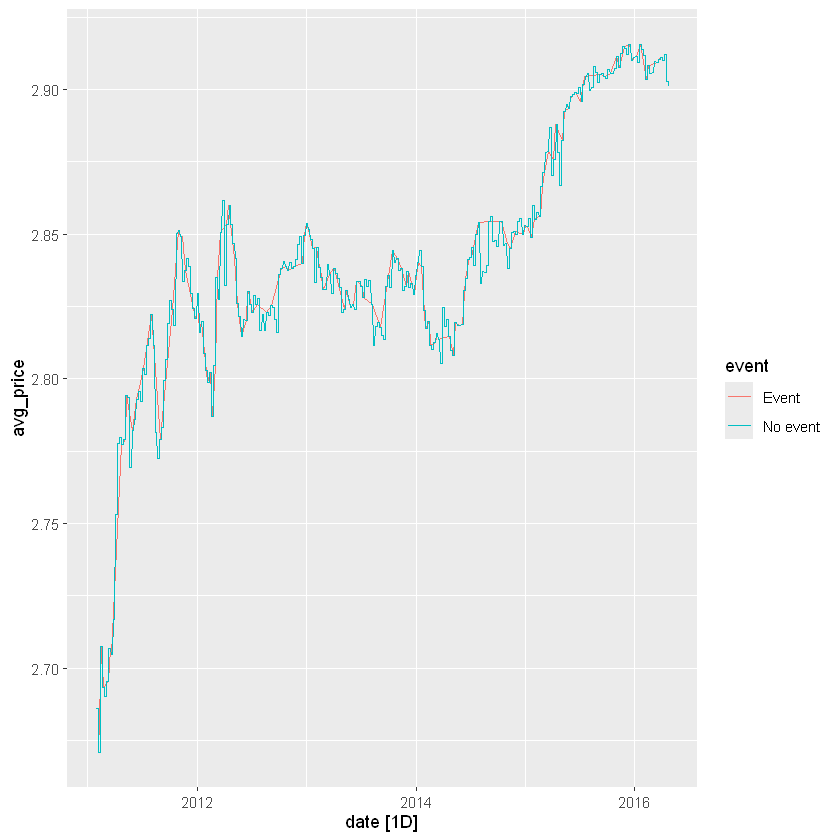

In [225]:
full_dataset%>%
  filter(!is.na(sell_price)) %>%
  mutate(event = if_else(is.na(event_name_1), "No event", "Event")) %>%
  group_by(date, event) %>%
  summarise(avg_price = mean(sell_price), .groups = "drop") %>%
  as_tsibble(key = event, index = date) %>%
  autoplot(avg_price)

Sales per weekday

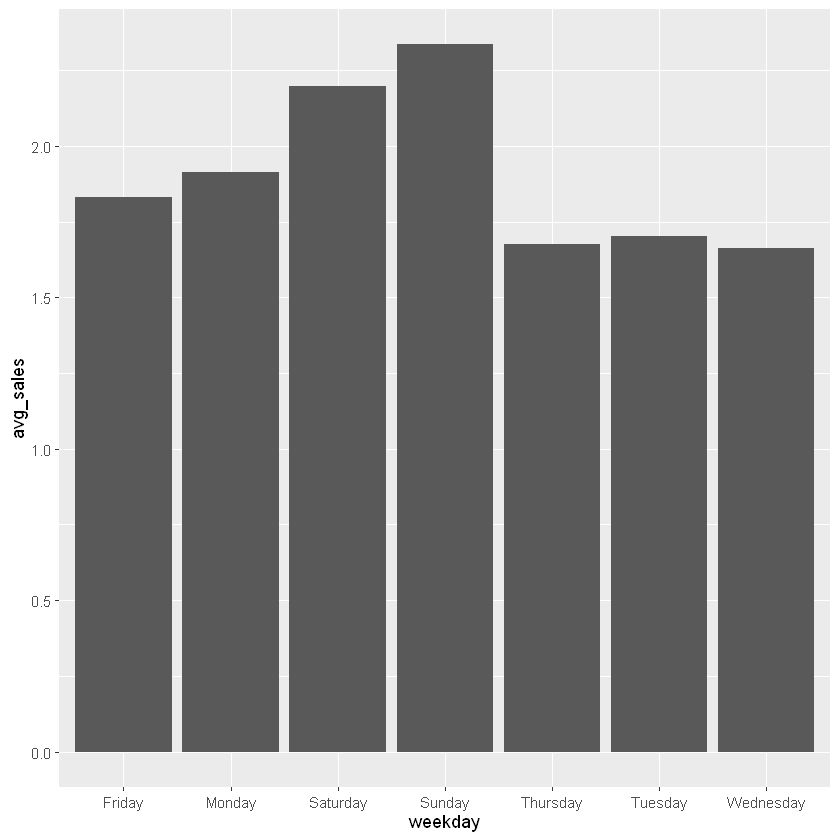

In [226]:
full_dataset%>%
  group_by(weekday) %>%
  summarise(avg_sales = mean(units_sold)) %>%
  ggplot(aes(weekday, avg_sales)) +
  geom_col()

Sales per category

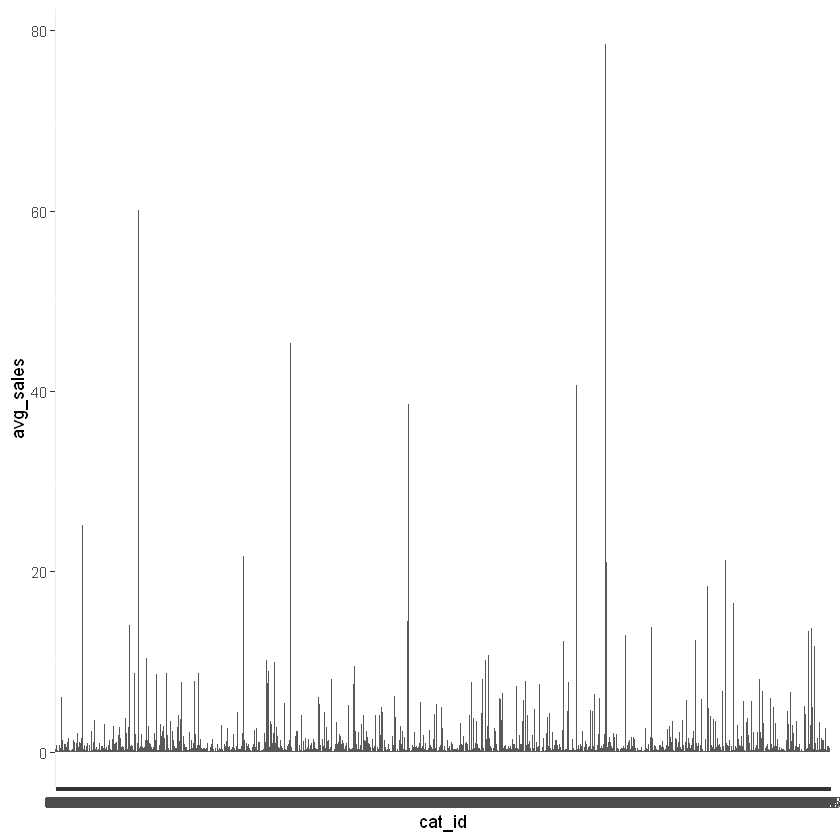

In [227]:
full_dataset%>%
  group_by(cat_id) %>%
  summarise(avg_sales = mean(units_sold)) %>%
  ggplot(aes(cat_id, avg_sales)) +
  geom_col()

Event Impact

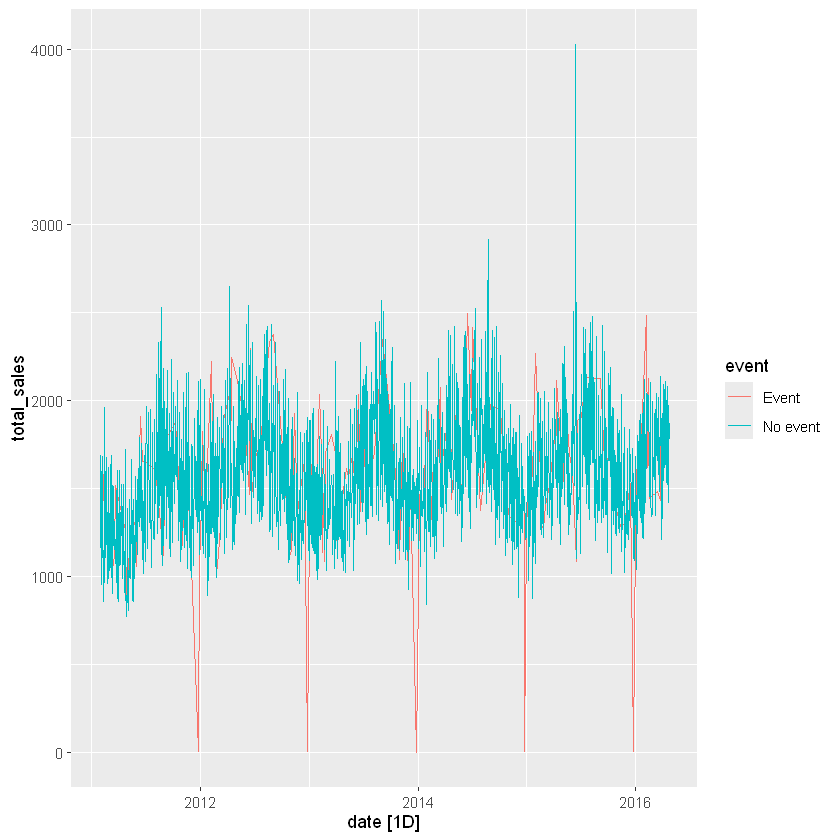

In [228]:
full_dataset%>%
  mutate(event = if_else(is.na(event_name_1), "No event", "Event")) %>%
  group_by(date, event) %>%
  summarise(total_sales = sum(units_sold), .groups = "drop") %>%
  as_tsibble(key = event, index = date) %>%
  autoplot(total_sales)


SNAP effect

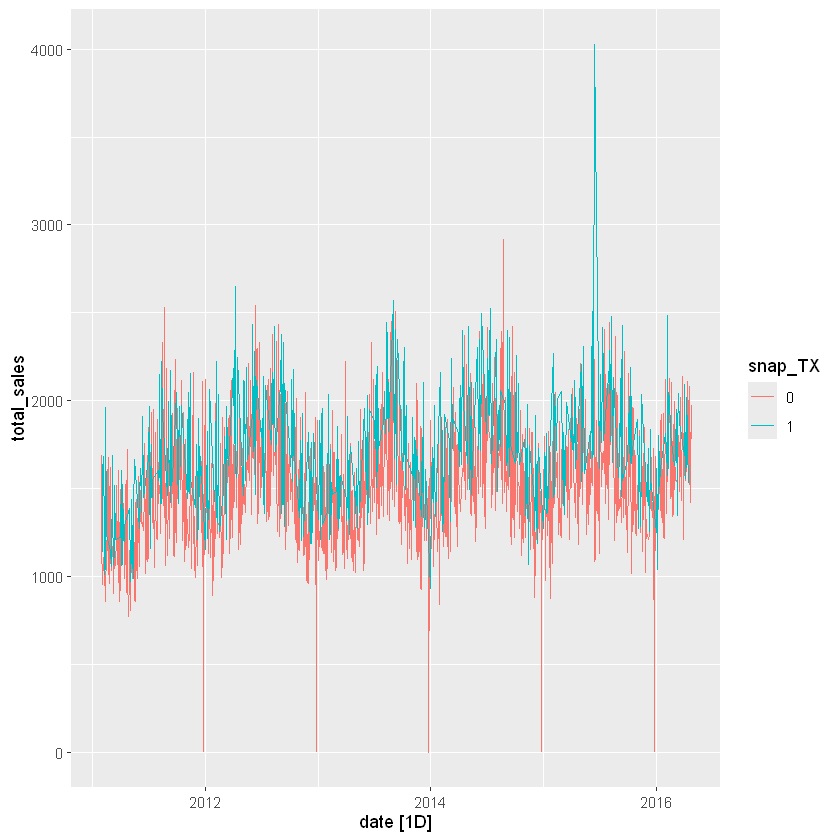

In [229]:
 full_dataset%>%
  group_by(date, snap_TX) %>%
  summarise(total_sales = sum(units_sold), .groups = "drop") %>%
  as_tsibble(key = snap_TX, index = date) %>%
  autoplot(total_sales)

**Total Sales**

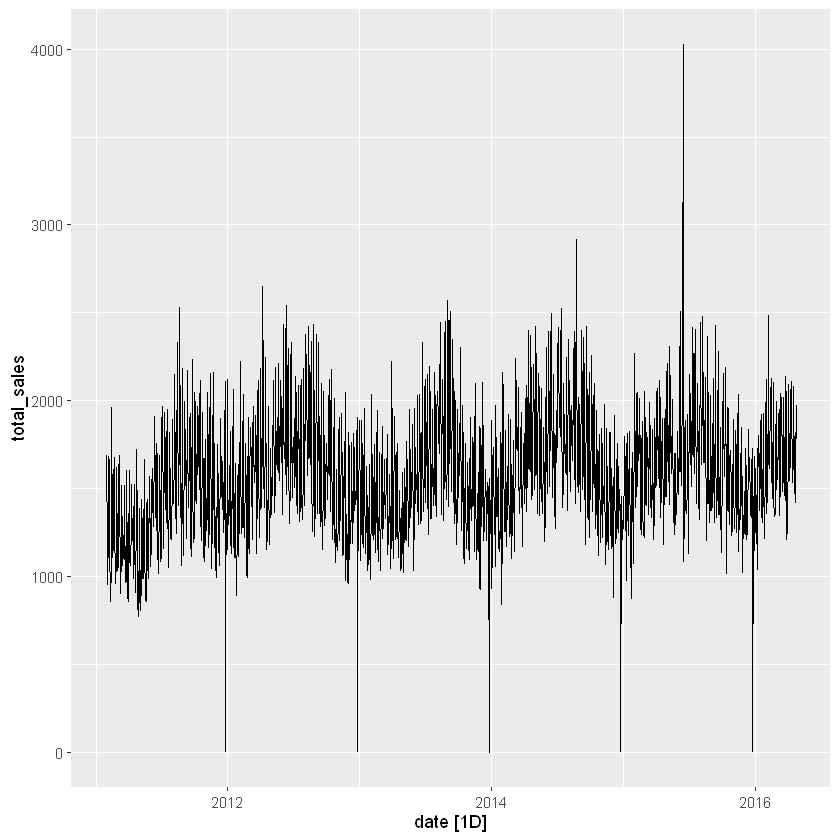

In [230]:
full_dataset%>%
  group_by(date) %>%
  summarise(total_sales = sum(units_sold)) %>%
  as_tsibble(index = date) %>%
  autoplot(total_sales)

Weekly sales

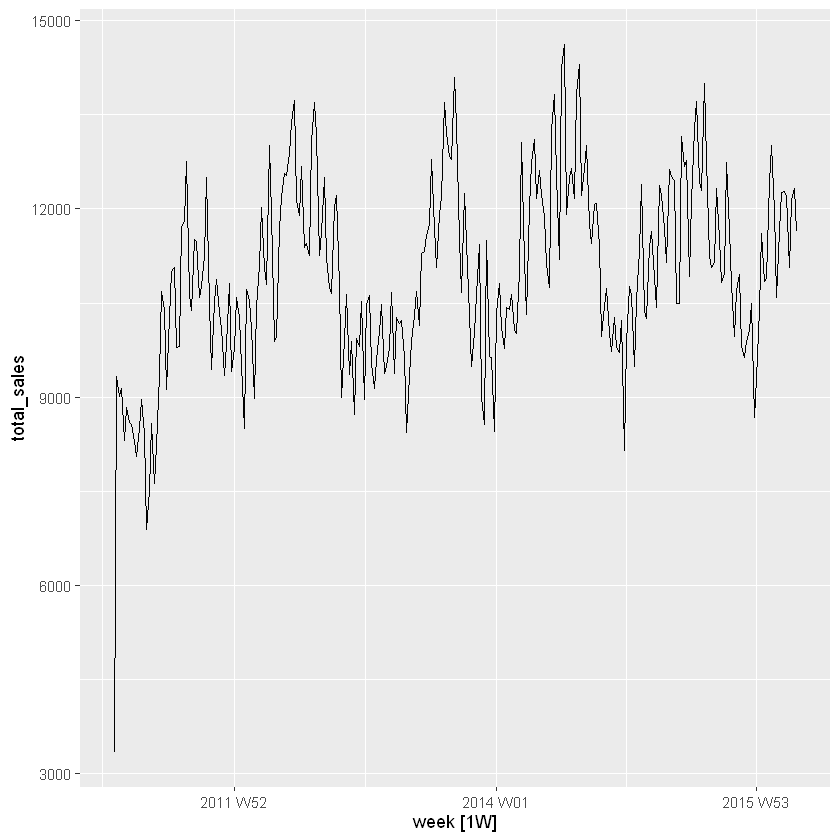

In [231]:
full_dataset %>%
  group_by(week = yearweek(date)) %>%
  summarise(total_sales = sum(units_sold), .groups = "drop") %>%
  as_tsibble(index = week) %>%
  autoplot(total_sales)

*STL Decomposition*

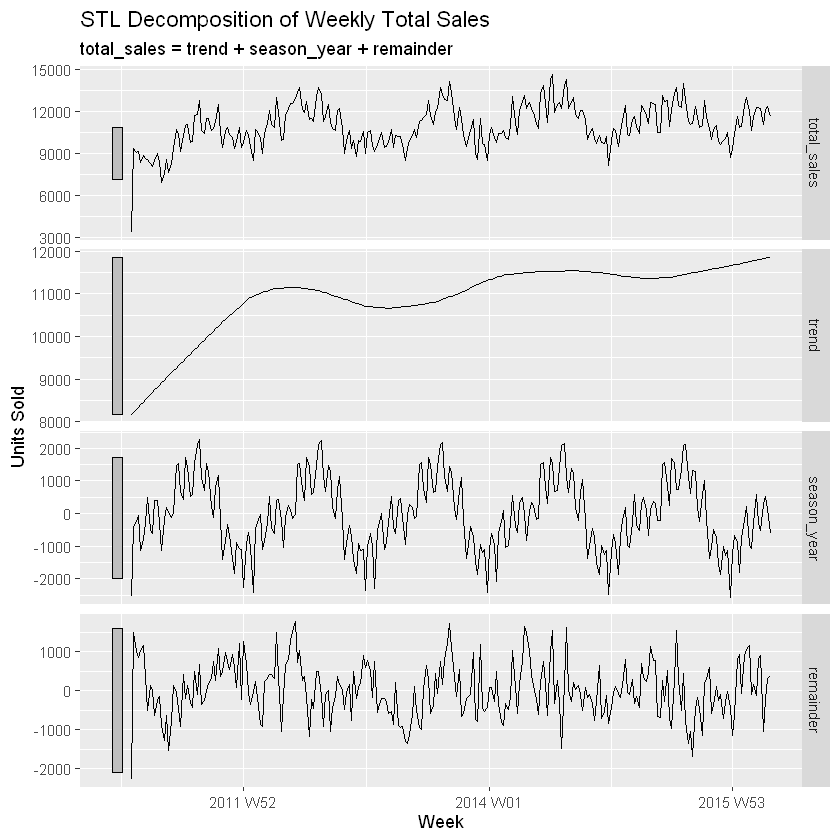

In [233]:
full_dataset %>%
  group_by(week = yearweek(date)) %>%
  summarise(total_sales = sum(units_sold), .groups = "drop") %>%
  as_tsibble(index = week) %>%
  model(STL(total_sales)) %>%
  components() %>%
  autoplot() +
  labs(
    title = "STL Decomposition of Weekly Total Sales",
    x = "Week",
    y = "Units Sold"
  )


Increasing trend  
Seasonality (same pattern every year)

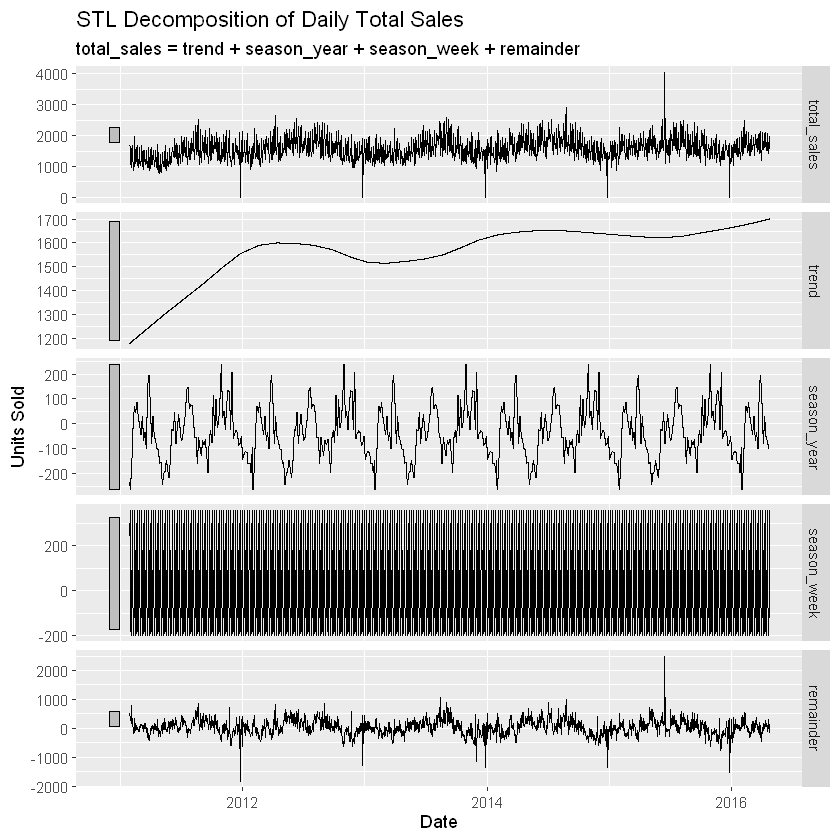

In [234]:
full_dataset %>%
  group_by(date) %>%
  summarise(total_sales = sum(units_sold), .groups = "drop") %>%
  as_tsibble(index = date) %>%
  model(
    STL(total_sales ~ season(window = "periodic"))
  ) %>%
  components() %>%
  autoplot() +
  labs(
    title = "STL Decomposition of Daily Total Sales",
    x = "Date",
    y = "Units Sold"
  )